# Задание 1. SHAP и коррелированные табличные данные

Изучите коррелированность вещественных признаков для датасета [AqSolDB 🎓[article]](https://www.nature.com/articles/s41597-019-0151-1), объединяющего информацию о растворимости химических веществ из разных источников.

Обучите линейную регрессию и оцените важность вещественных признаков, используя веса перед ними.

Обучите градиентный бустинг из библиотеки XGBoost для вещественных признаков.

Визуализируйте важность вещественных признаков в XGBoost, используя SHAP.




## Формат результата

В результате выполнения задания необходимо получить:
* таблицу с оценкой важности признаков с помощью их весов в линейной регрессии,
* таблицу важности признаков для XGBoost,
* SHAP-визуализацию важности признаков XGBoost.

Примеры визуализации:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.4/Exercises/EX14/result_1_1_task_ex14.png" width="500"><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.4/Exercises/EX14/result_2_1_task_ex14.png" width="500">

## Коррелированность вещественных признаков

Установка и импорт необходимых библиотек:

In [1]:
!pip install -q shap lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

Загрузка датасета:

In [ ]:
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/curated-solubility-dataset.csv

In [ ]:
data = pd.read_csv("curated-solubility-dataset.csv")
data.head()

ID                                               Name  \
0  A-3         N,N,N-trimethyloctadecan-1-aminium bromide   
1  A-4                           Benzo[cd]indol-2(1H)-one   
2  A-5                               4-chlorobenzaldehyde   
3  A-8  zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...   
4  A-9  4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...   

                                               InChI  \
0  InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...   
1  InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...   
2        InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H   
3  InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...   
4  InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...   

                      InChIKey  \
0  SZEMGTQCPRNXEG-UHFFFAOYSA-M   
1  GPYLCFQEKPUWLD-UHFFFAOYSA-N   
2  AVPYQKSLYISFPO-UHFFFAOYSA-N   
3  XTUPUYCJWKHGSW-UHFFFAOYSA-L   
4  FAUAZXVRLVIARB-UHFFFAOYSA-N   

                                              SMILES  Solubility   SD  \
0                [Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C   -3.616127  0.0   
1                               O=C1Nc2cccc3cccc1c23   -3.254767  0.0   
2                                    Clc1ccc(C=O)cc1   -2.177078  0.0   
3  [Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...   -3.924409  0.0   
4  C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...   -4.662065  0.0   

   Ocurrences Group    MolWt  ...  NumRotatableBonds  NumValenceElectrons  \
0           1    G1  392.510  ...               17.0                142.0   
1           1    G1  169.183  ...                0.0                 62.0   
2           1    G1  140.569  ...                1.0                 46.0   
3           1    G1  756.226  ...               10.0                264.0   
4           1    G1  422.525  ...               12.0                164.0   

   NumAromaticRings  NumSaturatedRings  NumAliphaticRings  RingCount    TPSA  \
0               0.0                0.0                0.0        0.0    0.00   
1               2.0                0.0                1.0        3.0   29.10   
2               1.0                0.0                0.0        1.0   17.07   
3               6.0                0.0                0.0        6.0  120.72   
4               2.0                4.0                4.0        6.0   56.60   

    LabuteASA      BalabanJ      BertzCT  
0  158.520601  0.000000e+00   210.377334  
1   75.183563  2.582996e+00   511.229248  
2   58.261134  3.009782e+00   202.661065  
3  323.755434  2.322963e-07  1964.648666  
4  183.183268  1.084427e+00   769.899934  

[5 rows x 26 columns]

Для обучения будем пользоваться только вещественными признаками. Целевой переменной будет `Solubility` (растворимость).

In [ ]:
features = data.loc[:, "MolWt":]
target = data["Solubility"]

Разбиение данных на обучающую и тестовую выборки:

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

Ознакомьтесь с матрицей корреляции вещественных признаков.

In [ ]:
corr = x_train.corr()

cmap = sns.diverging_palette(5, 250, as_cmap=True)

corr.style.background_gradient(cmap, axis=1).format(precision=3)

Найдем для каждого признака тот, с которым у него максимальная корреляция:

In [ ]:
corr_np = corr.to_numpy()
np.fill_diagonal(corr_np, 0)  # remove self correlations 1 -> 0

max_corr_ids = np.argmax(np.abs(corr_np), axis=1)  # find index of max corr. feature
max_corr_feature = x_train.columns[max_corr_ids]

max_corr_value = np.max(np.abs(corr_np), axis=1)


max_correlations = pd.DataFrame(
    {
        "feature": x_train.columns,
        "max_corr_feature": max_corr_feature,
        "abs_corrcoef": max_corr_value,
    }
)

max_correlations

feature     max_corr_feature  abs_corrcoef
0                 MolWt            LabuteASA      0.971521
1               MolLogP                MolMR      0.500434
2                 MolMR  NumValenceElectrons      0.976358
3        HeavyAtomCount  NumValenceElectrons      0.993122
4         NumHAcceptors       NumHeteroatoms      0.898048
5            NumHDonors                 TPSA      0.610531
6        NumHeteroatoms        NumHAcceptors      0.898048
7     NumRotatableBonds  NumValenceElectrons      0.717779
8   NumValenceElectrons       HeavyAtomCount      0.993122
9      NumAromaticRings              BertzCT      0.829284
10    NumSaturatedRings    NumAliphaticRings      0.896532
11    NumAliphaticRings    NumSaturatedRings      0.896532
12            RingCount              BertzCT      0.810546
13                 TPSA       NumHeteroatoms      0.897068
14            LabuteASA       HeavyAtomCount      0.983559
15             BalabanJ            LabuteASA      0.378659
16              BertzCT       HeavyAtomCount      0.901921

## Линейная регрессия для вещественных признаков

Обучите модель линейной регрессии `LinearRegression` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) на вещественных признаках датасета. **Не забудьте стандартизовать данные!**

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


In [ ]:
model_lr = LinearRegression()
model_lr.fit(x_train_scaled,y_train)

LinearRegression()

Для линейной регрессии в качестве меры важности признаков могут использоваться веса перед ними.

In [ ]:
linear_importance = pd.DataFrame(
    {"feature": x_train.columns, "linreg_coef": model_lr.coef_}
)

importance = max_correlations.merge(linear_importance, on="feature")
importance['abs_linreg_coef'] = abs(importance['linreg_coef'])
importance.sort_values(by="linreg_coef", ascending=False)

feature     max_corr_feature  abs_corrcoef  linreg_coef  \
8   NumValenceElectrons       HeavyAtomCount      0.993122     4.809274   
16              BertzCT       HeavyAtomCount      0.901921     2.603915   
2                 MolMR  NumValenceElectrons      0.976358     1.140097   
4         NumHAcceptors       NumHeteroatoms      0.898048     0.535803   
7     NumRotatableBonds  NumValenceElectrons      0.717779     0.315525   
5            NumHDonors                 TPSA      0.610531     0.215981   
10    NumSaturatedRings    NumAliphaticRings      0.896532     0.143248   
15             BalabanJ            LabuteASA      0.378659    -0.025318   
13                 TPSA       NumHeteroatoms      0.897068    -0.075147   
11    NumAliphaticRings    NumSaturatedRings      0.896532    -0.078921   
12            RingCount              BertzCT      0.810546    -0.449027   
9      NumAromaticRings              BertzCT      0.829284    -0.493917   
6        NumHeteroatoms        NumHAcceptors      0.898048    -0.739342   
14            LabuteASA       HeavyAtomCount      0.983559    -0.742702   
0                 MolWt            LabuteASA      0.971521    -0.758080   
1               MolLogP                MolMR      0.500434    -1.536503   
3        HeavyAtomCount  NumValenceElectrons      0.993122    -6.595637   

    abs_linreg_coef  
8          4.809274  
16         2.603915  
2          1.140097  
4          0.535803  
7          0.315525  
5          0.215981  
10         0.143248  
15         0.025318  
13         0.075147  
11         0.078921  
12         0.449027  
9          0.493917  
6          0.739342  
14         0.742702  
0          0.758080  
1          1.536503  
3          6.595637

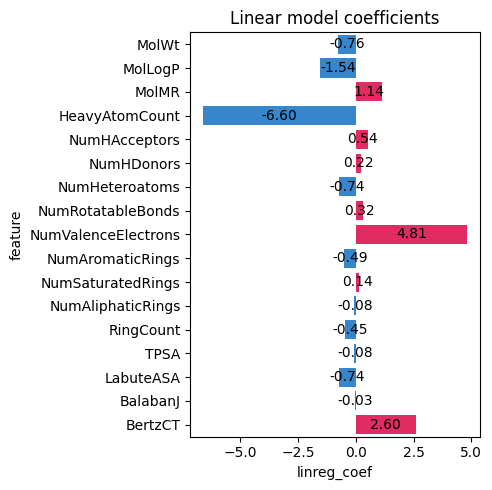

In [ ]:
linear_importance["sign"] = linear_importance["linreg_coef"].apply(
    lambda x: "neg" if x < 0 else "pos"
)
palette = {"neg": "#1e88e5", "pos": "#ff0d57"}
plt.figure(figsize=(5, 5))
plt.title("Linear model coefficients")

ax = sns.barplot(
    data=linear_importance,
    y="feature",
    x="linreg_coef",
    hue="sign",
    palette=palette,
    legend=False,
    orient="h",
)
for i in ax.containers:
    ax.bar_label(i, fmt="%.2f", label_type="center")
plt.tight_layout()
plt.show()

**Напишите вывод:**
Признаки с высокой корреляцией (HeavyAtomCount и NumValenceElectrons) имеют большие и противоположнные по знаку коэффициенты линейной модели. Модель пытается распределить компенсировать схожую информацию, распределяя веса коррелирующих признаков с разными знаками. Таким образом важность, определенная по линейной регрессии, не будет соответстсвовать реальной важности признака.



## XGBoost для вещественных признаков

Обучите градиентный бустинг из библиотеки XGBoost:

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.3)
model_xgb.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Извлеките [важности признаков 🛠️[doc]](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor.feature_importances_) обученной модели и добавьте их в таблицу `importance`.

In [ ]:
feature_importances_xgb = pd.DataFrame(
    {"feature": x_train.columns, "xgb_importance": model_xgb.feature_importances_}
)
importance = importance.merge(feature_importances_xgb, on="feature")
importance

feature     max_corr_feature  abs_corrcoef  linreg_coef  \
0                 MolWt            LabuteASA      0.971521    -0.758080   
1               MolLogP                MolMR      0.500434    -1.536503   
2                 MolMR  NumValenceElectrons      0.976358     1.140097   
3        HeavyAtomCount  NumValenceElectrons      0.993122    -6.595637   
4         NumHAcceptors       NumHeteroatoms      0.898048     0.535803   
5            NumHDonors                 TPSA      0.610531     0.215981   
6        NumHeteroatoms        NumHAcceptors      0.898048    -0.739342   
7     NumRotatableBonds  NumValenceElectrons      0.717779     0.315525   
8   NumValenceElectrons       HeavyAtomCount      0.993122     4.809274   
9      NumAromaticRings              BertzCT      0.829284    -0.493917   
10    NumSaturatedRings    NumAliphaticRings      0.896532     0.143248   
11    NumAliphaticRings    NumSaturatedRings      0.896532    -0.078921   
12            RingCount              BertzCT      0.810546    -0.449027   
13                 TPSA       NumHeteroatoms      0.897068    -0.075147   
14            LabuteASA       HeavyAtomCount      0.983559    -0.742702   
15             BalabanJ            LabuteASA      0.378659    -0.025318   
16              BertzCT       HeavyAtomCount      0.901921     2.603915   

    abs_linreg_coef  xgb_importance  
0          0.758080        0.035989  
1          1.536503        0.516290  
2          1.140097        0.037083  
3          6.595637        0.022353  
4          0.535803        0.027731  
5          0.215981        0.026962  
6          0.739342        0.035423  
7          0.315525        0.032429  
8          4.809274        0.031873  
9          0.493917        0.021007  
10         0.143248        0.014061  
11         0.078921        0.022487  
12         0.449027        0.019343  
13         0.075147        0.034495  
14         0.742702        0.027023  
15         0.025318        0.034461  
16         2.603915        0.060991

In [ ]:
def importances_diagram(data, x, y, title, fmt="%.2f"):
    plt.title(title)
    ax = sns.barplot(
        data=data,
        y=y,
        x=x,
        color=sns.xkcd_rgb["azure"],
        orient="h",
    )
    for i in ax.containers:
        ax.bar_label(i, fmt=fmt, label_type="edge")

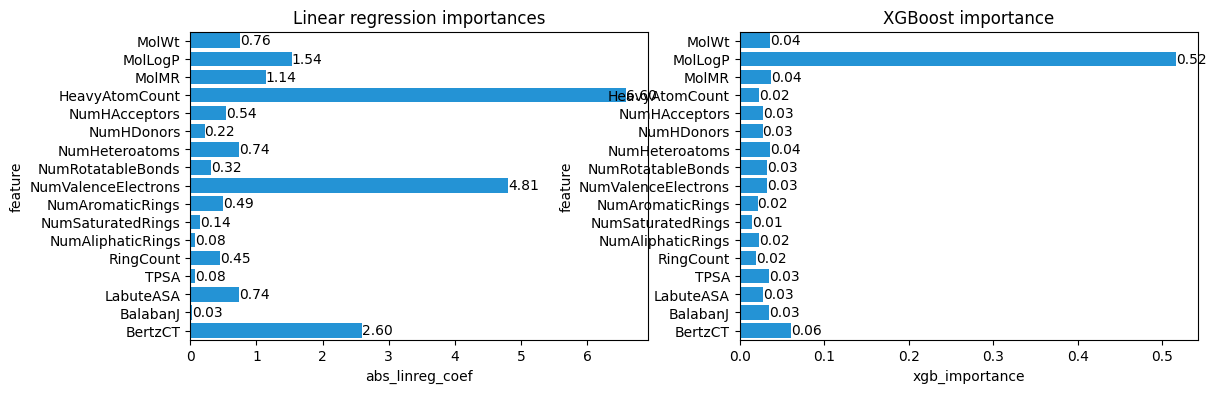

In [ ]:
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
importances_diagram(
    data=importance,
    x="abs_linreg_coef",
    y="feature",
    title="Linear regression importances",
)

plt.subplot(1, 2, 2)
importances_diagram(
    data=importance,
    x="xgb_importance",
    y="feature",
    title="XGBoost importance",
)
plt.show()

Сравните важности признаков для линейной регрессии и XGBoost. Как они связаны с корреляцией? Какая оценка важности адекватнее? Почему?

Линейная модель чувствительна к мультиколлинеарности. Сильно коррелирующие признаки могут получать противоположные по знаку, но большие по модулю коэффициенты. Такая оценка не будет отражать реальную важность признаков. XGBoost менее подвержена мультиколлинеарности и учитывает нелинейные зависимости между признаками. Такая оценка будет более адекватной.

## Визуализация SHAP для вещественных признаков

Выведите предсказание модели градиентного бустинга для одного объекта обучающей выборки с помощью метода `predict`.

In [ ]:
sample_idx = 20
sample = x_train.iloc[[sample_idx]]
sample

MolWt  MolLogP    MolMR  HeavyAtomCount  NumHAcceptors  NumHDonors  \
2859  167.296   2.2634  51.7034            12.0            1.0         1.0   

      NumHeteroatoms  NumRotatableBonds  NumValenceElectrons  \
2859             1.0                1.0                 70.0   

      NumAromaticRings  NumSaturatedRings  NumAliphaticRings  RingCount  \
2859               0.0                3.0                3.0        3.0   

       TPSA  LabuteASA  BalabanJ     BertzCT  
2859  26.02  75.716901  2.114733  185.443134

In [ ]:
prediction = model_xgb.predict(sample).item()

assert type(prediction) == float, f"prediction must be float, not {type(prediction)}. Use prediction.item()"
print(f"XGB prediction for sample #{sample_idx}: {prediction:.3f}")

XGB prediction for sample #20: -2.417


Создайте SHAP-модель объяснения предсказаний для модели градиентного бустинга. Используйте `shap.TreeExplainer` [🛠️[doc]](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.TreeExplainer.html).

Передайте SHAP-модели входные данные из обучающей выборки и получите для них SHAP-объяснения.

In [ ]:
explainer = shap.TreeExplainer(model_xgb)
explanations = explainer(x_train)

Посмотрите, из чего состоит объяснение для одного объекта

In [ ]:
explanation_sample = explanations[sample_idx]
explanation_sample

.values =
array([ 0.01164143,  0.03796243,  0.00125752,  0.05659979,  0.01615793,
        0.02822558,  0.01205504, -0.01644359, -0.1842334 ,  0.00646046,
        0.08249564, -0.08325717, -0.05007647,  0.21464199,  0.12707171,
       -0.00816534,  0.21453515], dtype=float32)

.base_values =
np.float32(-2.8839693)

.data =
array([167.296     ,   2.2634    ,  51.7034    ,  12.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
        70.        ,   0.        ,   3.        ,   3.        ,
         3.        ,  26.02      ,  75.71690056,   2.11473346,
       185.44313396])

Важным свойством [чисел Шепли 🎓[arxiv]](https://arxiv.org/abs/1705.07874) (SHAP-значений) является то, что их сумма, к которой также прибавлено базовое значение, должна совпасть с предсказанием модели:

$$\large  f(x) = \phi_0 + \sum_{i=1}^{M} \phi_i,$$

где:

$f(x)$ — предсказание модели,

$\phi_0$ — базовое значение,

$M$ — число признаков,

$\phi_i$ — число Шепли, характеризующее вклад $i$-го признака в предсказание.

Убедитесь, что сумма SHAP-значений для признаков вместе с базовым значением дает предсказание модели.

In [ ]:
shap_values_sum = explanation_sample.values.sum() + explanation_sample.base_values

print(f"Sum of shap values for sample #{sample_idx}: {shap_values_sum:.3f}")
print(f"XGB prediction for sample #{sample_idx}: {prediction:.3f}")

assert np.allclose(shap_values_sum, prediction), "Oops, something wrong! Maybe you've forgot add base value? Look here: https://clck.ru/9TFat"
print("Good work! This is for you: https://clck.ru/38ZE8r")

Sum of shap values for sample #20: -2.417
XGB prediction for sample #20: -2.417
Good work! This is for you: https://clck.ru/38ZE8r


При помощи `shap.plots.force` [🛠️[doc]](https://shap.readthedocs.io/en/latest/generated/shap.plots.force.html#shap-plots-force) объясните предсказание модели градиентного бустинга для данного объекта из обучающей выборки. Перед построением визуализации не забудьте вызвать `shap.initjs()`.

In [ ]:
shap.initjs()
shap.plots.force(explanation_sample)

Объясните предсказание для этого же объекта при помощи `shap.plots.waterfall` [🛠️[doc]](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html?highlight=waterfall).

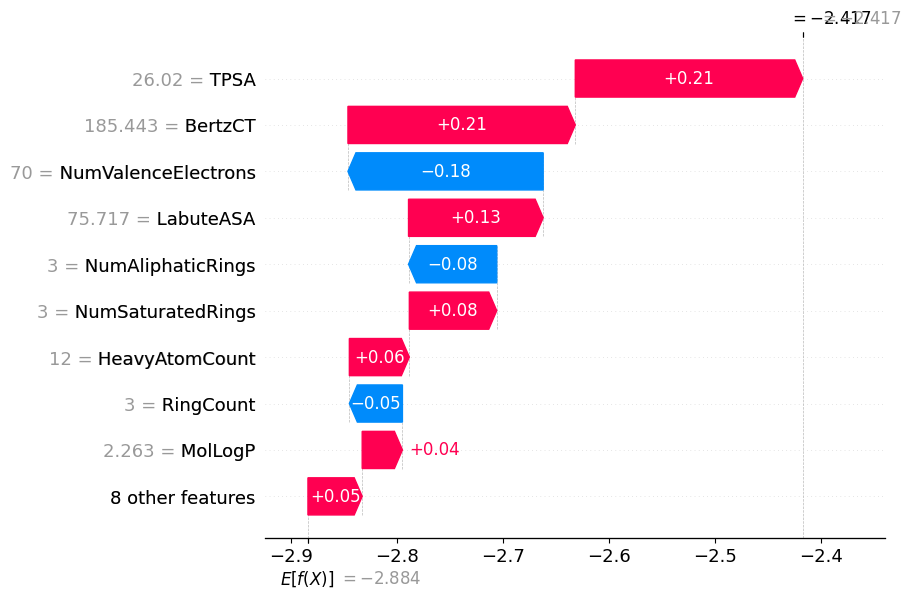

In [ ]:
shap.plots.waterfall(explanation_sample)

Используя `shap.plots.bar` [🛠️[doc]](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html), `shap.plots.beeswarm` [🛠️[doc]](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html?highlight=beeswarm#A-simple-beeswarm-summary-plot) и `shap.plots.violin` [🛠️[doc]](https://shap.readthedocs.io/en/latest/generated/shap.plots.violin.html#shap-plots-violin), посмотрите на важность признаков в целом.

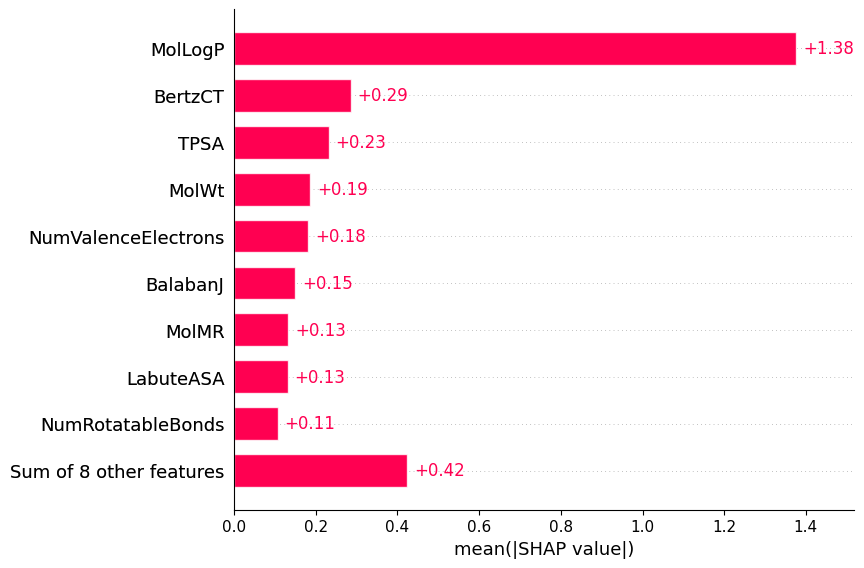

In [ ]:
# Your code here
shap.plots.bar(explanations)

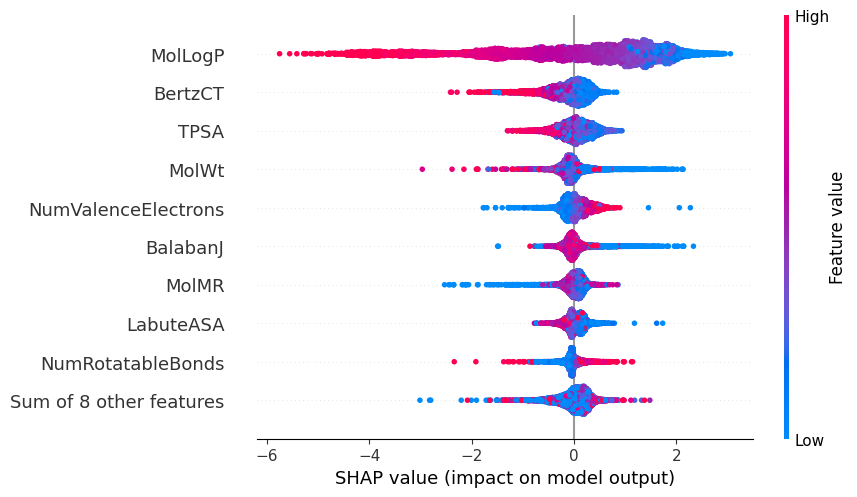

In [ ]:
# Your code here
shap.plots.beeswarm(explanations)

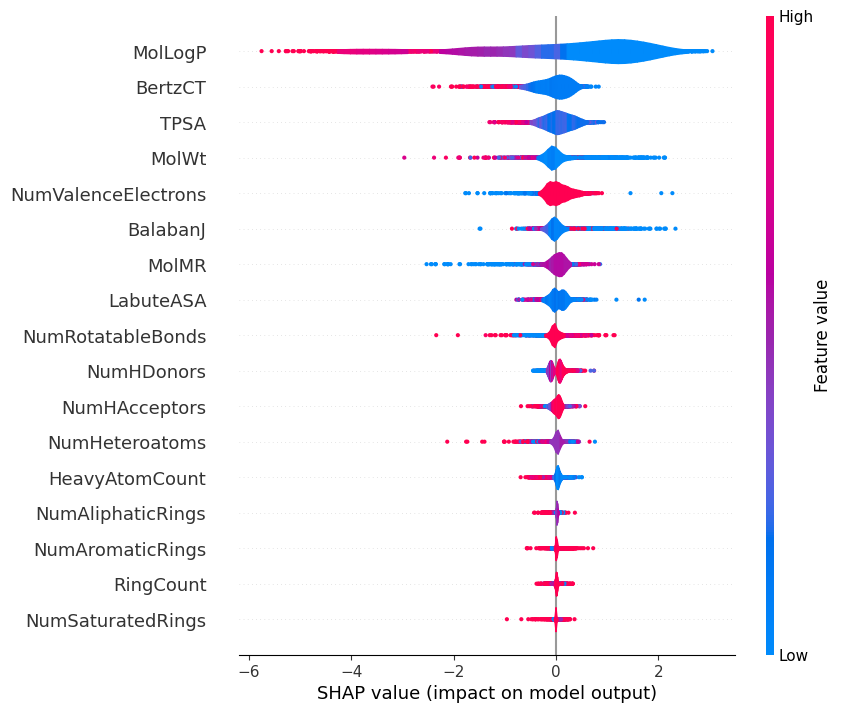

In [ ]:
# Your code here
shap.plots.violin(explanations)

Постройте waterfall-объяснение предсказания для молекулы из **тестовой** выборки, для которой предсказано наименьшее значение `Solubility`:

In [ ]:
test_predictions = model_xgb.predict(x_test)

x_test_sorted = x_test.reset_index(drop=True)
y_test_sorted = y_test.reset_index(drop=True)

test_pred_df = pd.DataFrame({"Solubility": test_predictions})
test_pred_sorted = test_pred_df.sort_values(by="Solubility")

x_test_sorted = x_test_sorted.loc[test_pred_sorted.index]
y_test_sorted = y_test_sorted.loc[test_pred_sorted.index]

x_test_sample = x_test_sorted.iloc[[0]]
print(x_test_sample)
print(y_test_sorted.iloc[0])

       MolWt  MolLogP    MolMR  HeavyAtomCount  NumHAcceptors  NumHDonors  \
177  514.661  10.0129  103.058            23.0            1.0         0.0   

     NumHeteroatoms  NumRotatableBonds  NumValenceElectrons  NumAromaticRings  \
177            11.0                2.0                124.0               2.0   

     NumSaturatedRings  NumAliphaticRings  RingCount  TPSA   LabuteASA  \
177                0.0                0.0        2.0  9.23  180.634705   

     BalabanJ     BertzCT  
177  2.712767  690.954533  
-12.95


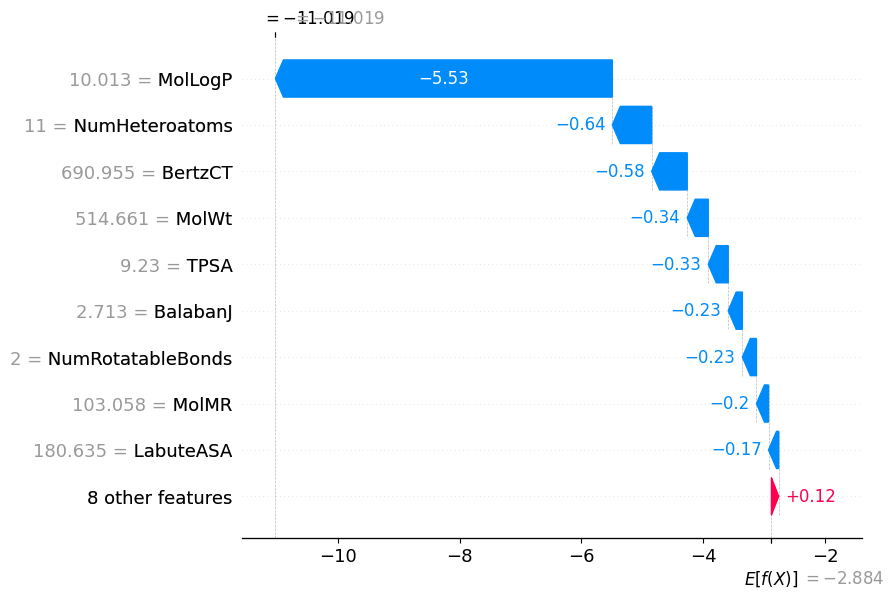

In [ ]:
explanation_test = explainer(x_test_sample)
shap.plots.waterfall(explanation_test[0])

In [ ]:
shap_values = explanations.values
shap_importance = np.abs(shap_values).mean(axis=0)
feature_importances_shap = pd.DataFrame(
    {"feature": explanations.feature_names, "shap_importance": shap_importance}
)
importance = importance.merge(feature_importances_shap, on="feature")
importance

feature     max_corr_feature  abs_corrcoef  linreg_coef  \
0                 MolWt            LabuteASA      0.971521    -0.758080   
1               MolLogP                MolMR      0.500434    -1.536503   
2                 MolMR  NumValenceElectrons      0.976358     1.140097   
3        HeavyAtomCount  NumValenceElectrons      0.993122    -6.595637   
4         NumHAcceptors       NumHeteroatoms      0.898048     0.535803   
5            NumHDonors                 TPSA      0.610531     0.215981   
6        NumHeteroatoms        NumHAcceptors      0.898048    -0.739342   
7     NumRotatableBonds  NumValenceElectrons      0.717779     0.315525   
8   NumValenceElectrons       HeavyAtomCount      0.993122     4.809274   
9      NumAromaticRings              BertzCT      0.829284    -0.493917   
10    NumSaturatedRings    NumAliphaticRings      0.896532     0.143248   
11    NumAliphaticRings    NumSaturatedRings      0.896532    -0.078921   
12            RingCount              BertzCT      0.810546    -0.449027   
13                 TPSA       NumHeteroatoms      0.897068    -0.075147   
14            LabuteASA       HeavyAtomCount      0.983559    -0.742702   
15             BalabanJ            LabuteASA      0.378659    -0.025318   
16              BertzCT       HeavyAtomCount      0.901921     2.603915   

    abs_linreg_coef  xgb_importance  shap_importance  
0          0.758080        0.035989         0.186815  
1          1.536503        0.516290         1.376960  
2          1.140097        0.037083         0.132929  
3          6.595637        0.022353         0.069161  
4          0.535803        0.027731         0.074244  
5          0.215981        0.026962         0.105120  
6          0.739342        0.035423         0.073606  
7          0.315525        0.032429         0.107517  
8          4.809274        0.031873         0.181586  
9          0.493917        0.021007         0.025360  
10         0.143248        0.014061         0.019008  
11         0.078921        0.022487         0.033469  
12         0.449027        0.019343         0.024227  
13         0.075147        0.034495         0.232015  
14         0.742702        0.027023         0.131029  
15         0.025318        0.034461         0.149727  
16         2.603915        0.060991         0.285891

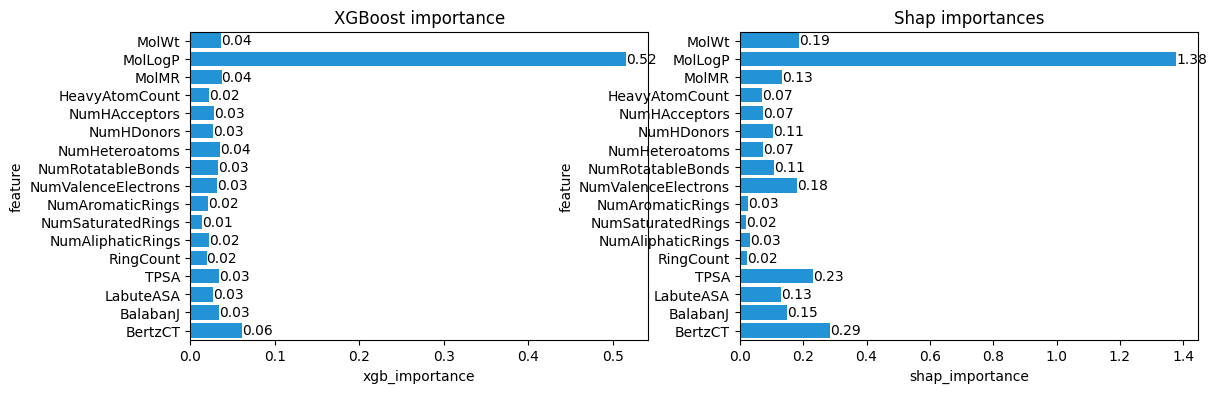

In [ ]:
plt.figure(figsize=(13, 4))

plt.subplot(1, 2, 1)
importances_diagram(
    data=importance,
    x="xgb_importance",
    y="feature",
    title="XGBoost importance",
)
plt.subplot(1, 2, 2)
importances_diagram(
    data=importance,
    x="shap_importance",
    y="feature",
    title="Shap importances",
)
plt.show()

Сравните результаты оценки признаков с помощью
`xgb.feature_importances_` и SHAP. **Напишите вывод.**

**Вывод:**

Оба метода выделили MolLogP как самый важный признак. Но у XGBoost все признаки, кроме MolLogP имеют низкую важность и мало отличаются по этой важности. В Shap MolLogP также самый важный, но разница между ним и другими признаками менее резкая. Признаки вроде BertzCT, TPSA, LabuteASA и MolWt также показывают значительный вклад. Также XGBoost занизил важность сильно коррелирующих между собой признаков, а Shap позволяет увидеть вклад каждого признака, даже если они скоррелированы.



# Задание 2. SHAP. NLP: Классификация эмоциональной окраски отзывов

Дана NLP-модель: трансформер, обученный на задаче предсказания эмоциональной окраски (`"POSITIVE"`/`"NEGATIVE"`) отзыва.

Изучите результат работы модели с помощью SHAP:
* Ознакомьтесь с работой `tokenizer`, форматом входных данных и результатом работы модели.
* Ознакомьтесь с форматом выдачи SHAP.
* Убедитесь, что сумма SHAP-значений для одного объекта равна предсказанию модели на этом объекте.
* Визуализируйте SHAP-объяснения предсказаний модели.
* Выберите отзывы с IMDb и визуализируйте предсказания для них.

## Формат результата

Результатом работы является:
* функция `shap_val_to_pred(shap_val)`, рассчитывающая предсказанные моделью вероятности классов, используя выдачу SHAP. Результат выполнения тестового блока должен выглядеть так:

```
examples[0]: OK
examples[1]: OK
examples[2]: OK
examples[3]: OK
```
* визуализация важности признаков с помощью `shap.plots.text` [🛠️[doc]](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/text.html)

Пример визуализации:
<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.4/Exercises/EX14/result_2_task_ex14.png" width="1000">

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -q shap transformers

In [ ]:
import math
import shap
import torch
import transformers
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TextClassificationPipeline,
)

In [ ]:
torch.manual_seed(42)

## Tokenizer и модель

Загрузим `tokenizer` (предобрабатывает предложения, прежде чем подать их в модель):

In [ ]:
from IPython.display import clear_output


tokenizer_name = "distilbert-base-uncased"
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained(tokenizer_name)

clear_output()

Работа `tokenizer`:

In [ ]:
print(tokenizer.tokenize("I'll be back"))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize("I'll be back")))
print(tokenizer.encode("I'll be back"))
print(tokenizer.convert_ids_to_tokens(tokenizer.encode("I'll be back")))

['i', "'", 'll', 'be', 'back']
[1045, 1005, 2222, 2022, 2067]
[101, 1045, 1005, 2222, 2022, 2067, 102]
['[CLS]', 'i', "'", 'll', 'be', 'back', '[SEP]']


`[CLS]` и `[SEP]` — [специальные токены 🛠️[doc]](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.sep_token).

In [ ]:
dict(zip(tokenizer.all_special_ids, tokenizer.all_special_tokens))

{100: '[UNK]', 102: '[SEP]', 0: '[PAD]', 101: '[CLS]', 103: '[MASK]'}

Загрузка трансформера, обученного на задаче предсказания позитивности/негативности отзыва:

In [ ]:
device = "cpu"
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model = transformers.DistilBertForSequenceClassification.from_pretrained(model_name).to(
    device
)

classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None)

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Device set to use cuda:0


Пример работы модели:

In [ ]:
examples = ["example", "example two", "example three the best", "professionalism"]
prediction = classifier(examples)
prediction

[[{'label': 'POSITIVE', 'score': 0.968960165977478},
  {'label': 'NEGATIVE', 'score': 0.031039882451295853}],
 [{'label': 'POSITIVE', 'score': 0.976680338382721},
  {'label': 'NEGATIVE', 'score': 0.023319678381085396}],
 [{'label': 'POSITIVE', 'score': 0.9998076558113098},
  {'label': 'NEGATIVE', 'score': 0.000192355495528318}],
 [{'label': 'POSITIVE', 'score': 0.9986911416053772},
  {'label': 'NEGATIVE', 'score': 0.0013089017011225224}]]

Форматируем выход: приводим в формат вида `list[dict{'NEGATIVE': val, 'POSITIVE': val},...]` с точностью значений 5 знаков после запятой.

In [ ]:
model_prediction = [
    {
        item[0]["label"]: round(item[0]["score"], 5),
        item[1]["label"]: round(item[1]["score"], 5),
    }
    for item in prediction
]
print(*model_prediction, sep="\n")

{'POSITIVE': 0.96896, 'NEGATIVE': 0.03104}
{'POSITIVE': 0.97668, 'NEGATIVE': 0.02332}
{'POSITIVE': 0.99981, 'NEGATIVE': 0.00019}
{'POSITIVE': 0.99869, 'NEGATIVE': 0.00131}


## Построение SHAP-объяснений

In [ ]:
explainer = shap.Explainer(classifier)
shap_vals = explainer(examples)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Результат работы SHAP для примера с индексом `1` (`"example two"`):

In [ ]:
shap_vals[1]

.values =
array([[ 0.        ,  0.        ],
       [-0.1031602 ,  0.1031602 ],
       [-0.14678626,  0.14678621],
       [ 0.        ,  0.        ]])

.base_values =
array([0.27326614, 0.72673392])

.data =
array(['', 'example ', 'two', ''], dtype=object)

Устройство объекта с объяснениями для одного примера:

* `shap_vals[idx].values` — массив размером `(количество токенов, количество классов)` — SHAP-значения для каждого токена при предсказании каждого класса

* `shap_vals[idx].base_values` — массив размером `(количество классов,)` — базовые значения для каждого класса

* `shap_vals[idx].data` — объясняемые данные (в данном случае содержит список токенов)

Объяснения для примера с индексом `1` для класса `"POSITIVE"`:

In [ ]:
shap_vals[1, :, "POSITIVE"]

.values =
array([0.        , 0.1031602 , 0.14678621, 0.        ])

.base_values =
np.float64(0.726733922958374)

.data =
array(['', 'example ', 'two', ''], dtype=object)

Напишите функцию, которая рассчитывает предсказанные моделью вероятности на основе SHAP-значений и базовых значений для
классов `"NEGATIVE"` и `"POSITIVE"` **для одного объекта**. Формат вывода `dict{'NEGATIVE': val, 'POSITIVE': val}` с точностью значений 5 знаков после запятой.

In [ ]:
def shap_val_to_pred(shap_val):
    positive_values = shap_val.values[:,1]
    negative_values = shap_val.values[:, 0]
    base_values = shap_val.base_values
    prediction = {
        "NEGATIVE": round(np.sum(negative_values) + base_values[0], 5),
        "POSITIVE": round(np.sum(positive_values) + base_values[1], 5),
    }
    return prediction


Тестовый блок:

In [ ]:
for i in range(len(shap_vals)):
    try:
        assert model_prediction[i] == shap_val_to_pred(shap_vals[i])
    except AssertionError:
        print(
            f"""examples[{i}]: Error, sum of shap values not equal to pred!
             pred: {model_prediction[i]} shap sum {shap_val_to_pred(shap_vals[i])}"""
        )
    else:
        print(f"examples[{i}]: OK")

examples[0]: OK
examples[1]: OK
examples[2]: OK
examples[3]: OK


## Визуализация SHAP

Напишите функцию для визуализации объяснения предсказания модели с использованием `shap.plots.text` [🛠️[doc]](https://shap.readthedocs.io/en/latest/generated/shap.plots.text.html#shap-plots-text). Перед построением визуализации не забудьте вызвать `shap.initjs()`.

In [ ]:
def score_and_visualize(model, text):
    prediction = model(text)
    print(prediction)
    explainer = shap.Explainer(model)
    shap_values = explainer(text)
    shap.initjs()
    shap.plots.text(shap_values)

Проверка работы функции:

In [ ]:
score_and_visualize(classifier, ["example three the best"])

[[{'label': 'POSITIVE', 'score': 0.9998076558113098}, {'label': 'NEGATIVE', 'score': 0.000192355495528318}]]


Выберите какие-то сериалы или фильмы, которые вам особенно нравятся и не нравятся. Возьмите с сайта [IMDb](https://www.imdb.com/) один позитивный и один негативный отзыв.

Визуализируйте предсказание модели с помощью функции `score_and_visualize`.

In [ ]:
print("POSITIVE REVIEW")
score_and_visualize(classifier, ['''This is one of the best films that I have ever seen and is my favorite adaptation of my favorite novel. It's been about a decade since last I read the novel, but because that was the second time that I read it I remember it well. This adaptation is faithful to what I remember-far more so than the 2002 Hollywood adaptation-and accurately captures the essential plot, characters, themes, and motifs such as betrayal, revenge, love, jealousy, identity, disguises, ect. A TV series can capture more detail than a 3 hour film, but as far as a 3 hour film goes this is as faithful as it can be to a 1500 page novel.
The movie cost around $50 million to film, and that is clearly evident because the set pieces, costume design, and acting are all top notch. '''])

POSITIVE REVIEW
[[{'label': 'POSITIVE', 'score': 0.999749481678009}, {'label': 'NEGATIVE', 'score': 0.0002505560696590692}]]


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:16, 16.60s/it]               


In [ ]:
print("NEGATIVE REVIEW")
score_and_visualize(classifier, ['''The screenwriter doesn't seem to have read the book or have the least idea of what it is about. It is not itan adaptation its an act of vandalism, full of ridiculous changes to the characters and the ditching of several far more interesting ones. The narrative is all over the placeand adds nothing of value and detracts from the story. The Count, very badly acted, comes across as an insipid bore and none of the other characters is interesting or well played. I have seen many film versions of this fantastic novel and this by far the worst version I have seen. I can only recommend it if you are having trouble sleeping.'''])

Output hidden; open in https://colab.research.google.com to view.

На какие словосочетания модель больше всего реагирует? Согласны ли вы с ее вердиктом?

**Напишите вывод:**

Модель действительно правильно классифицировала отзывы на положительные и отрицательные (Первый отзыв был взят с оценкой 10, а второй - 1). Видно, что модель при оценке ориентируется на правильные "позитивные" и "негативные" слова. В первом случае это all top, well, best. Во втором - worst,ridiculous,having trouble.

# Задание 3. GradCAM для Imagenette

В этом задании от вас требуется получить и визуализировать GradCAM-карты активаций для сверточной нейронной сети, обученной на датасете [Imagenette 🐾[git]](https://github.com/fastai/imagenette).

Imagenette &mdash; это подвыборка оригинального датасета Imagenet, в которой отобраны изображения десяти самых легко классифицируемых классов. Это классы:

*   tench (линь),
*   English springer (Английский спрингер-спаниель),
*   cassette player (кассетный проигрыватель),
*   chain saw (бензопила),
*   church (церковь),
*   French horn (валторна),
*   garbage truck (мусоровоз),
*   gas pump (бензонасос),
*   golf ball (мяч для гольфа),
*   parachute (парашют).


## Формат результата

В результате должна получиться визуализация для десяти изображений разных классов. Для каждого изображения требуется определить предсказанный моделью класс и визуализировать карты активаций для всех классов.

Пример визуализации:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.4/Exercises/EX14/result_1_3_task_ex14.png" width="600">

Установка и импорт необходимых библиотек:

In [3]:
!pip install -q lightning torchmetrics
!pip install -q grad-cam
!pip install -q timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import torch
import random
import numpy as np
import torchmetrics
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torchsummary import summary
from torchvision.transforms import v2
from pytorch_grad_cam import GradCAM
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

## Загрузка датасета

In [5]:
!wget -qN https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/imagenette2-320.tgz
!tar -xzf /content/imagenette2-320.tgz

In [6]:
from torchvision.datasets import ImageFolder

transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((224, 224)),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

train_data = ImageFolder("imagenette2-320/train", transform=transform)
val_data = ImageFolder("imagenette2-320/val", transform=transform)

batch_size = 128
train_loader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=2
)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

Классы в Imagenette представлены не самими именами, а специальными кодами:

In [7]:
val_data.classes

['n01440764',
 'n02102040',
 'n02979186',
 'n03000684',
 'n03028079',
 'n03394916',
 'n03417042',
 'n03425413',
 'n03445777',
 'n03888257']

Соберем словарь для перевода кода класса в имя, исходя из полного словаря классов Imagenet.

In [8]:
!wget -qN "https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.4/Exercises/EX14/imagenet_class_index.json"

In [9]:
import json

with open("/content/imagenet_class_index.json", "r") as read_file:
    imagenet_class_index = json.load(read_file)

id_to_name = {}

for key in imagenet_class_index:
    id = imagenet_class_index[key][0]
    name = imagenet_class_index[key][1]
    if id in val_data.classes:
        id_to_name[id] = name

id_to_name

{'n01440764': 'tench',
 'n02102040': 'English_springer',
 'n02979186': 'cassette_player',
 'n03000684': 'chain_saw',
 'n03028079': 'church',
 'n03394916': 'French_horn',
 'n03417042': 'garbage_truck',
 'n03425413': 'gas_pump',
 'n03445777': 'golf_ball',
 'n03888257': 'parachute'}

## Загрузка модели

Обученная модель имеет архитектуру ResNet18, в которой заменен последний слой для классификации десяти классов Imagenette.

In [10]:
import timm

model = timm.create_model(
    "resnet18.a1_in1k",
    pretrained=False,
    num_classes=10,
)

Скачаем обученные веса и загрузим их в модель:

In [11]:
!wget -qN https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.4/Exercises/EX14/ex14_task3_model_weights.ckpt

In [12]:
model.load_state_dict(
    torch.load(
        "ex14_task3_model_weights.ckpt",
        weights_only=True,
        map_location=torch.device("cpu"),
    )
)

<All keys matched successfully>

Посмотрим на размерности выходов слоев:

In [13]:
from torchsummary import summary

summary(model, (3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
          Identity-7           [-1, 64, 56, 56]               0
              ReLU-8           [-1, 64, 56, 56]               0
          Identity-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
       BasicBlock-13           [-1, 64, 56, 56]               0
           Conv2d-14           [-1, 64,

Убедимся, что модель обучена:

In [14]:
import torchmetrics


num_classes = len(val_data.classes)

accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
model.eval()

with torch.no_grad():
    for batch in val_loader:
        imgs, labels = batch

        pred = model(imgs.to(device)).cpu()

        accuracy.update(pred, labels)

print(f"Trained model accuracy: {accuracy.compute():.2%}")

Trained model accuracy: 96.64%


## Выбор изображений для визуализации

Отберем из тестовой выборки 10 изображений: по одному случайному изображению каждого класса. Соберем их в тензор `images`.

Сеть обучена на изображениях, к которым применена нормализация. Нам потребуются вспомогательные функции для применения нормализации изображений и инверсного преобразования для визуализации.

In [15]:
from PIL import Image


def open_img(path, transform):
    img = Image.open(path)
    img = transform(img)
    return img


def inverse_normalize(img, inverse_transform):
    img = inverse_transform(img)
    img = torch.clip(img, 0.0, 1.0)
    return img


inverse_transform = v2.Compose(
    [
        v2.Normalize([0.0, 0.0, 0.0], [1 / 0.229, 1 / 0.224, 1 / 0.225]),
        v2.Normalize([-0.485, -0.456, -0.406], [1.0, 1.0, 1.0]),
    ]
)

In [16]:
idx = []
for class_num in range(num_classes):
    # find indexes of all images of current class_num
    matched_idx = np.where(np.array(val_data.targets) == class_num)[0]
    # convert them to list
    matched_idx = matched_idx.tolist()

    # choice index of random image of current class_num
    idx.append(random.choice(matched_idx))

images = []
for id in idx:
    images.append(open_img(val_data.imgs[id][0], transform))
images = torch.stack(images)
print(images.shape)

torch.Size([10, 3, 224, 224])


Отобразим изображения и убедимся, что они отобрались верно:

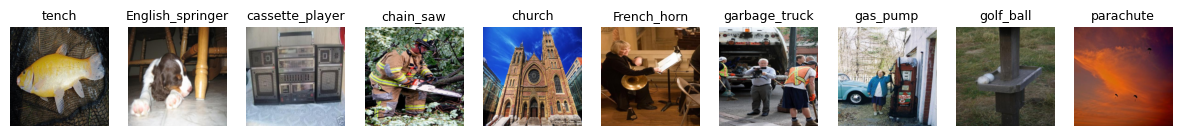

In [17]:
plt.figure(figsize=(15, 3))

for i in range(num_classes):
    plt.subplot(1, num_classes, i + 1)
    plt.imshow(inverse_normalize(images[i], inverse_transform).permute(1, 2, 0))
    plt.axis("off")
    plt.title(id_to_name[val_data.classes[i]], fontsize=9)
plt.show()

## Получение GradCAM-карт активаций

Выведем внутреннее устройство модели. Карты активаций для GradCAM будем брать из последнего блока модели перед `global_pool`:

In [18]:
model = model.cpu()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

В `target_layers` укажите нужный модуль модели. Здесь `target_layers` — список из одного элемента.

Затем создайте объект `cam` как экземпляр класса `GradCAM`. При создании объекта передайте в конструктор класса модель и `target_layers`.

In [20]:
from pytorch_grad_cam import GradCAM


target_layers = [model.layer4[-1].conv2]
cam = GradCAM(model=model, target_layers=target_layers)

1. Возьмите **одно** изображение из тензора `images`. Тензор должен иметь размер `(1, 3, 224, 224)`. Для согласованности с кодом лекции рекомендуется назвать его `img_t`.

2. Создайте numpy-аналог изображения для последущей визуализации. Для визуализации изображение нужно пропустить через функцию `inverse_normalize`. Размер массива должен быть `(224, 224, 3)`. Для согласованности с кодом лекции рекомендуется назвать его `img_arr`.

3. Подайте тензор с изображением в модель, получите вектор предсказанных вероятностей классов `prediction` размером `(10,)`.

4. Определите номер и название самого вероятного класса, предсказанного моделью (`predicted_class` и `predicted_class_name`). Список названий классов можно получить из `val_data.classes` и словаря `id_to_name`.



In [24]:
img_t = images[0].unsqueeze(0)
img_arr = inverse_normalize(img_t, inverse_transform)
print(img_arr.shape)

torch.Size([1, 3, 224, 224])


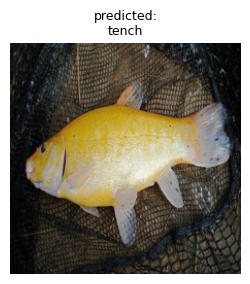

In [40]:
import torch.nn.functional as F

img_t = images[0].unsqueeze(0)
img_arr = inverse_normalize(img_t, inverse_transform)[0].permute(1, 2, 0).numpy()

model.eval()
with torch.no_grad():
  prediction = model(img_t)[0]
  prediction = F.softmax(prediction, dim=0)

predicted_class = torch.argmax(prediction)
predicted_class_name = id_to_name[val_data.classes[predicted_class]]

plt.figure(figsize=(3, 3))
plt.imshow(img_arr)
plt.title(f"predicted:\n{predicted_class_name}", fontsize=9)
plt.axis("off")
plt.show()

Получите GradCAM-карту активаций для предсказанного (самого вероятного) класса для данного изображения. Размер карты активаций `cam_map` должен быть `(224, 224)` (без числа каналов).

cam_map.shape is (224, 224)


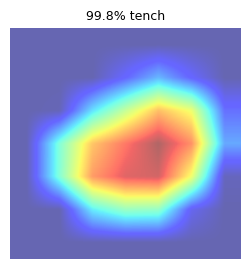

In [41]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


target =  [ClassifierOutputTarget(predicted_class)]
cam_map = cam(input_tensor=img_t, targets=target)[0]

assert cam_map.shape == (
    224,
    224,
), f"cam_map.shape is {cam_map.shape}. Please remove channel dimension"

# Nothing to change here
print(f"cam_map.shape is {cam_map.shape}")
plt.figure(figsize=(3, 3))
plt.imshow(
    cam_map,
    alpha=0.6,
    interpolation="bilinear",
    cmap="jet",
)
plt.title(
    f"{prediction[predicted_class].item():.1%} {id_to_name[val_data.classes[predicted_class]]}",
    fontsize=9
)
plt.axis("off")
plt.show()

Теперь получите и отобразите карты активаций для всех классов для данного одного изображения.

Предлагаем воспользоваться `plt.subplot(1, num_classes + 1)`. Сначала выведите оригинальное изображение на первом `subplot`, а затем в цикле по классам получите и выведите карты активаций для всех классов. Формат визуализации:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.4/Exercises/EX14/result_2_3_task_ex14.png" width="1000">

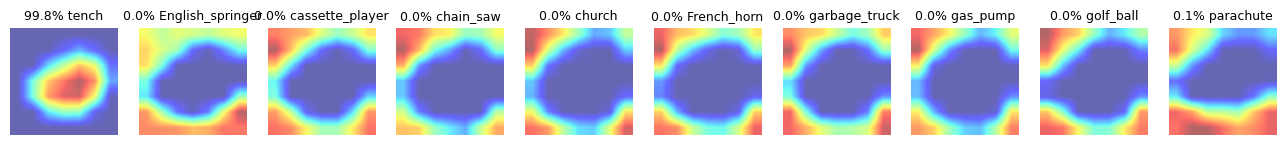

In [50]:
plt.figure(figsize=(18,3))

for i in range(num_classes):
    grayscale_cam = cam(input_tensor=img_t, targets=[ClassifierOutputTarget(i)])
    cam_map = grayscale_cam[0]

    plt.subplot(1, num_classes + 1, i + 2)
    plt.imshow(cam_map, alpha=0.6,
    interpolation="bilinear",
    cmap="jet",)
    plt.title(
    f"{prediction[i].item():.1%} {id_to_name[val_data.classes[i]]}",
    fontsize=9
    )
    plt.axis("off")

plt.show()

В цикле по всем изображениям в тензоре `images` повторите действия, с которыми вы получили визуализацию выше.

In [65]:
plt.figure(figsize=(5 * (num_classes + 1), 5 * len(images)))

for j in range(len(images)):
    img_t = images[j].unsqueeze(0)
    img_arr = inverse_normalize(img_t, inverse_transform)[0].permute(1, 2, 0).numpy()

    model.eval()
    model.to(device)
    with torch.no_grad():
        prediction = model(img_t.to(device))[0].detach().cpu()
        prediction = F.softmax(prediction, dim=0)

    cam = GradCAM(model=model, target_layers=target_layers)

    plt.subplot(len(images), num_classes + 1, j * (num_classes + 1) + 1)
    plt.imshow(img_arr)
    plt.title(id_to_name[val_data.classes[j]], fontsize=9)
    plt.axis("off")

    for i in range(num_classes):
        grayscale_cam = cam(input_tensor=img_t.to(device), targets=[ClassifierOutputTarget(i)])
        cam_map = grayscale_cam[0]

        plt.subplot(len(images), num_classes + 1, j * (num_classes + 1) + i + 2)
        plt.imshow(cam_map, alpha=0.6, interpolation="bilinear", cmap="jet")
        plt.title(f"{prediction[i].item():.1%} {id_to_name[val_data.classes[i]]}", fontsize=9)
        plt.axis("off")

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

Проанализируйте полученные результаты, опишите свои наблюдения и замечания:

Видно, что в большинстве случаев для классов, не соответствующих целевому, градиент распределяется везде, кроме области, соответствуюшей объекту. А для целевых классов подсвечивает области, соответствующие объекту. Прикольно, что для изображения с заправкой в классе garbage_truck захватывается машина.
Для некоторых классов модель так же ориентируется на фон. Для chainsaw захватывается область не только инструмента, но и окружения - типа листвы.

В целом модель уверенно выделяет области объекта релевантвного класса, а для нерелевантных объектов избегается область целевого класса. В некоторых случаях модель ориентируется ещё и на контекст. Может быть зависимость от сцены.

P.S. а почему яйца - это golf_ball 🤔

# Задание 4*. Adversarial attack

В прошлых заданиях мы писали **ResNet**, теперь попробуем его “сломать”. Будем изменять входное изображение, чтобы получать разные предсказания модели. Сначала изменим изображение, чтобы увеличить вероятность предсказываемого класса, а затем изменим изображение, чтобы модель предсказала класс, который не входил в топ-5 предсказаний на оригинальном изображении.

Для этого нужно:
1. Скачать изображение и сохранить оригинальную картинку. Можно использовать изображение из лекции или скачать любое изображение из интернета.
**Совет:** *используйте `!wget`, это позволит воспроизвести код без ручной загрузки картинки (по крайней мере, пока ссылка на картинку будет доступна).*

2. Сделать предсказание с помощью предобученной ResNet-18. Выбрать класс с максимальной вероятностью.

3. Довести вероятность максимально вероятного класса до 98% (сильно больше не нужно, т.к. при длительном обучении картинка может начать деградировать). Сохранить картинку с увеличенной вероятностью наиболее вероятного класса. Посчитать среднюю разницу между картинками.

**Совет:** *для изменения картинки можно использовать оптимизатор с флагом `maximize=True`.*

4. Выбрать класс, который не входит в топ-5. Довести его вероятность до 98%. Сохранить картинку с увеличенной вероятностью класса, который не входит в топ-5. Посчитать среднюю разницу между сохраненной и оригинальной картинкой.

5. Построить карты важности для оригинальной картинки, картинки с увеличенным основным классом и случайным классом двумя градиентными способами.

6. Сделать визуализацию, написать вывод.

**Общий совет:** градиентные методы, меняя значения пикселей, могут вывести их за границы от 0 до 1. Для восстановления диапазона можете использовать функцию `clip`. Финальные вероятности, разницы и объяснения имеет смысл делать для изображений после восстановления диапазона (возможно, вам придется денормализовать и нормализовать изображение).

## Формат результата
* Визуализация результата (картинка может отличаться).
<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.4/Exercises/EX14/result_4_task_ex14.png" width="700">
* Средняя разница значений пикселей между исходным и модифицированным изображением.
* Вывод.


Установка и импорт необходимых библиотек:

In [66]:
!pip install -q grad-cam

In [67]:
!pip install -q captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 30.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [68]:
import os
import json
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import models
from torchvision.transforms import v2
from matplotlib import pylab as P
from pytorch_grad_cam import GradCAM
from captum.attr import IntegratedGradients
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

Установим Captum отдельно — после импорта всех остальных библиотек, поскольку в последнем на текущий момент релизе (`v0.8.0`) эта библиотека всё ещё поддерживает PyTorch версии `< 2.3.0` и, соответственно, ограничивает версию NumPy до `< 2.0`. Предварительная установка Captum может вызвать ошибки при импорте других библиотек.

In [69]:
from captum.attr import IntegratedGradients

Загрузка модели и меток классов:

In [70]:
!wget -q "https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.4/Exercises/EX14/cat_and_dog.jpg" -O cat_and_dog.jpg
!wget -q "https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.4/Exercises/EX14/imagenet_class_index.json" -O imagenet_class_index.json

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights="ResNet18_Weights.DEFAULT")

idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath("/content/imagenet_class_index.json"), "r") as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    lable2idx = {class_idx[str(k)][1]: k for k in range(len(class_idx))}

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 86.7MB/s]


In [74]:
model.eval()
model.to(device)

transform = v2.Compose([
    v2.Resize(224),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return torch.clip(img * std + mean, 0, 1)
img_path = "/content/cat_and_dog.jpg"
orig_img = Image.open(img_path).convert("RGB")
input_tensor = transform(orig_img).unsqueeze(0).to(device).requires_grad_(True)


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [102]:
with torch.no_grad():
    output = model(input_tensor)
    probs = F.softmax(output, dim=1)
    top5 = torch.topk(probs, 5)
    top_class = top5.indices[0, 0].item()
    excluded_class = torch.argmax((probs * (1 - F.one_hot(top5.indices[0], 1000).sum(dim=0))).float()).item()
print(f"Top class: {top_class} ({idx2label[top_class]})")
print(f"Class not in top-5: {excluded_class} ({idx2label[excluded_class]})")

Top class: 281 (tabby)
Class not in top-5: 673 (mouse)


In [103]:
def optimize_class(input_tensor, target_class, max_iter=200, lr=0.01):
    img = input_tensor.clone().detach().to(device)
    img.requires_grad = True
    optimizer = torch.optim.Adam([img], lr=lr)

    for _ in range(max_iter):
        optimizer.zero_grad()
        output = model(img)
        prob = F.softmax(output, dim=1)[0, target_class]
        loss = -torch.log(prob)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            img.clamp_(-3, 3)
        if prob.item() >= 0.98:
            break
    return img.detach(), prob.item()

In [104]:
optimized_top_img, final_prob_top = optimize_class(input_tensor, top_class)
optimized_rand_img, final_prob_rand = optimize_class(input_tensor, excluded_class)
orig_vis = denormalize(input_tensor[0].cpu())
top_vis = denormalize(optimized_top_img[0].cpu())
rand_vis = denormalize(optimized_rand_img[0].cpu())
diff_top = torch.mean(torch.abs(orig_vis - top_vis)).item()
diff_rand = torch.mean(torch.abs(orig_vis - rand_vis)).item()

print(f"Top class prob after opt: {final_prob_top:.4f}, diff: {diff_top:.4f}")
print(f"Random class prob after opt: {final_prob_rand:.4f}, diff: {diff_rand:.4f}")

Top class prob after opt: 0.9834, diff: 0.0075
Random class prob after opt: 0.9867, diff: 0.0071


In [105]:
def grad_to_image(raw_grads, percentile=99):
    gradients = raw_grads.detach().cpu().numpy()
    gradients = np.transpose(gradients, (0, 2, 3, 1))[0]

    image_2d = np.sum(np.abs(gradients), axis=2)

    vmax = np.percentile(image_2d, percentile)
    vmin = np.min(image_2d)

    return np.clip((image_2d - vmin) / (vmax - vmin), 0, 1)

def compute_integrated_gradients(model, input_tensor, target_class):
    ig = IntegratedGradients(model)
    attributions_ig = ig.attribute(input_tensor, target=target_class, n_steps=200)

    return grad_to_image(attributions_ig)

def compute_gradcam(model, input_tensor, target_class, target_layer):
    model.eval()
    img_for_overlay = denormalize(input_tensor[0].detach().cpu()).permute(1,2,0).numpy()

    cam = GradCAM(model=model, target_layers=[target_layer])

    targets = [ClassifierOutputTarget(target_class)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    return grayscale_cam

target_layer = model.layer4[-1]

images = [orig_vis, top_vis, rand_vis]
inputs = [input_tensor, optimized_top_img, optimized_rand_img]
titles = ["Original", "Max original class", f'Excluded class {excluded_class}']

ig_maps = []
gradcam_maps = []

for inp, target in zip(inputs, [top_class, top_class, excluded_class]):
    inp = inp.detach().clone().to(device).requires_grad_(True)
    ig_map = compute_integrated_gradients(model, inp, target)
    gradcam_map = compute_gradcam(model, inp, target, target_layer)
    ig_maps.append(ig_map)
    gradcam_maps.append(gradcam_map)


In [106]:
class_names = [idx2label[top_class], idx2label[top_class], idx2label[excluded_class]]

fig, axs = plt.subplots(3, 3, figsize=(15, 12))

for i in range(3):
    axs[0, i].imshow(images[i].detach().permute(1, 2, 0).cpu().numpy())
    axs[0, i].set_title(f"{titles[i]}\nClass: {class_names[i]}")
    axs[0, i].axis("off")

    axs[1, i].imshow(ig_maps[i], cmap='gray')
    axs[1, i].set_title(f"Integrated Gradients\nClass: {class_names[i]}")
    axs[1, i].axis("off")

    axs[2, i].imshow(images[i].detach().permute(1, 2, 0).cpu().numpy())
    axs[2, i].imshow(gradcam_maps[i], interpolation="bilinear", cmap="jet", alpha=0.5)
    axs[2, i].set_title(f"Grad-CAM\nClass: {class_names[i]}")
    axs[2, i].axis("off")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

**Напишите вывод:**

IG: Оригинальное изображение - важны мордочки животных + фон рядом с котом. Усиление класса кота - мордочки больше подсвечены + сильнее подсвечивается стул, внимание смещается на фон. После активации класса мыши мордочки животных становятся менее выделенными и градиент размазан по животным, стулу и фоном рядом с котом.

GradCAM: Внимание сосредоточено на кошке, особенно голове и верхней части туловища. После усиления класса кота модель охватывает не только кота, но и частично области собаки и немного смещается к стулу. Вероятно, модель усиливает вклад сопутствующих признаков, ранее встречавшихся рядом с кошками. После активации класса мыши внимание так же сосредоточено на кошке, особенно на нижней части тела, при этом захватывается области и с собакой. В принципе, кот серый, мышь тоже серая и фиксация происходит на теле ниже морды кошки.

Grad CAM и Integrated Gradients показывают, что модель чётко ассоциирует класс "tabby" с котом, игнорируя собаку. При усилении вероятности класса кота активации расширяются на фон, что может указывать на зависимость от контекста.